In [ ]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [1]:
%matplotlib notebook
%autosave 0
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro

Autosave disabled


In [12]:
def model():
    mu_prior = pyro.sample("mean", pyro.distributions.Normal(0, 10))
    sd_prior = pyro.sample("sigma", pyro.distributions.HalfNormal(5, 10))
    return pyro.sample("obs", pyro.distributions.Normal(mu_prior, sd_prior))

def guide():
    mu_loc = pyro.param("mu_loc", torch.tensor([0.], dtype=torch.float32))
    mu_scale = pyro.param("mu_scale", torch.tensor([1.], dtype=torch.float32), 
                          constraint=torch.distributions.constraints.positive)
    sd_loc = pyro.param("sd_loc", torch.tensor([1.], dtype=torch.float32), 
                        constraint=torch.distributions.constraints.positive)
    sd_scale = pyro.param("sd_scale", torch.tensor([1], dtype=torch.float32), 
                          constraint=torch.distributions.constraints.positive)
    
    mu = pyro.sample("mean", pyro.distributions.Normal(mu_loc, mu_scale))
    sd = pyro.sample("sigma", pyro.distributions.Normal(sd_loc, sd_scale))

#from pyro.contrib.autoguide import AutoDiagonalNormal
#guide = AutoDiagonalNormal(model)

<IPython.core.display.Javascript object>


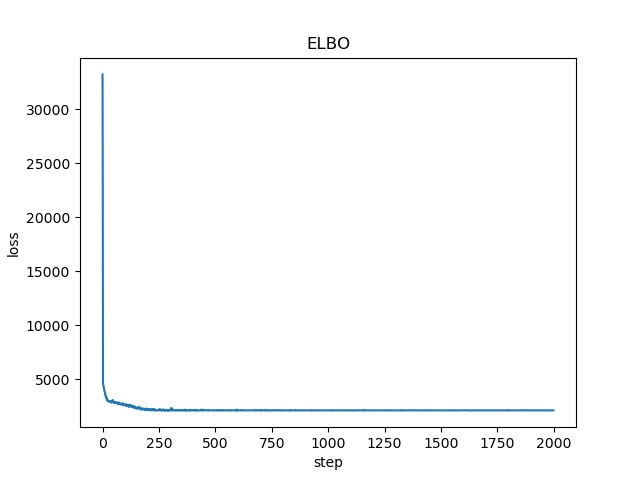

mu_loc tensor([4.9703], requires_grad=True)
mu_scale tensor([0.0959], grad_fn=<AddBackward0>)
sd_loc tensor([1.9882], grad_fn=<AddBackward0>)
sd_scale tensor([0.0793], grad_fn=<AddBackward0>)


In [13]:
pyro.clear_param_store()

data_torch = torch.from_numpy(data.astype('float32'))
conditioned_model = pyro.condition(model, data={"obs": data_torch})

svi = pyro.infer.SVI(model=conditioned_model,
                     guide=guide,
                     optim=pyro.optim.SGD({"lr": 1e-4}),
                     loss=pyro.infer.Trace_ELBO(),
                     num_samples=10)

losses, a,b  = [], [], []
num_steps = 2000
for epoch in range(num_steps):
    #a.append(pyro.param("mu").detach().numpy())
    #b.append(pyro.param("cov").detach().numpy())
    losses.append(svi.step())

fig, ax = plt.subplots()
ax.plot(losses)
ax.set_title("ELBO")
ax.set_xlabel("step")
ax.set_ylabel("loss");

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

In [ ]:
model()

In [ ]:
from matplotlib.patches import Ellipse
fig, ax = plt.subplots()
for i in [0, 100, 1000, -1]:
    ellipse = Ellipse((a[i][0], a[i][1]),
            width=b[i][0], height=b[i][1], facecolor='none', ls='--', edgecolor='k')

    ax.add_patch(ellipse)
    
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])

# Latent Variable Models

# Gaussian latent variable model: Probabilistic PCA



Matriz de datos $X = (x_1, x_2, \ldots, x_N)$ con $x_i \in \mathbb{R}^D$

Prior Gaussiano estándar
$$
p(z) = \mathcal{N}(z|0, I)
$$

$$
p(x|z)  = \mathcal{N}(x|Wz + \mu, I\sigma^2) 
$$

Verosimilitud marginal (evidencia)
$$
p(x) = \int p(x|z) p(z) \,dz = \mathcal{N}(x|\mu, W^T W + I\sigma^2 )
$$

y el posterior

$$
p(z|x) = \mathcal{N}(z|M^{-1}W^T(x-\mu), M\sigma^{-2} )
$$

donde

$$
M = W^T W + I\sigma^2
$$

Entrenamos maximizando la log verosimilitud
$$
\max \log L(W,\mu, \sigma^2) = \sum_{i=1}^N \log p(x_i)
$$


In [ ]:
%matplotlib notebook

import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import theano.tensor as tt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

N = 10000 
M = 3  # dimensions of the data
D = 2  # dimensions of the projection

np.random.seed(10)
C = np.random.randn(M, M)
C = np.dot(C.T, C)
X = np.random.multivariate_normal(np.zeros(shape=(M, )), C, size=N)
# In the general case we subtract the mean and divide by std, 
X = X - np.mean(X, axis=0)
X = X/np.std(X, axis=0)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=2)

pca = PCA(n_components=2, whiten=False)
R = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(R[:, 0], R[:, 1], s=1)
_ = plt.title('PCA projection')


In [ ]:


with pm.Model() as PPCA:
    s = pm.HalfCauchy('s', beta=5, shape=[1,])
    w = pm.Normal('w', mu=tt.zeros([D, M]), sd=tt.ones([D, M]), shape=[D, M])
    z = pm.Normal('z', mu=tt.zeros([N, D]), sd=tt.ones([N, D]), shape=[N, D])
    x = pm.Normal('x', mu=z.dot(w), sd=s*tt.ones([N, M]), shape=[N, M], observed=X)  
    inference = pm.ADVI()
    approx = pm.fit(n=2000, method=inference, obj_optimizer=pm.adam(learning_rate=1e-1))

_ = plt.plot(-inference.hist)
plt.ylabel('Evidence lower bound (ELBO)')
plt.xlabel('Iteration')
plt.grid()

with PPCA:
    trace = approx.sample(draws=1000)
    ppc = pm.sample_ppc(trace=trace, samples=100)
_ = pm.traceplot(trace=trace, varnames=['w', 's'])

W_avg = np.mean(trace['w'], axis=0)
s_avg = np.mean(trace['s'], axis=0)
print("Average W")
print(W_avg)
print("Average sigma: %f" %(s_avg))

x_reconstructed = ppc['x'][0, :, :]  # this is one draw from the posterior

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=2)
ax.set_title('Input data')             
bx, by, bz = ax.get_xbound(), ax.get_ybound(), ax.get_zbound()      
ax = fig.add_subplot(122, projection='3d')
ax.set_title("Sampled data")
ax.scatter(x_reconstructed[:, 0], x_reconstructed[:, 1], x_reconstructed[:, 2], s=1, alpha=0.5)
t = np.linspace(-4, 4, num=100)
ax.set_xbound(bx)
ax.set_ybound(by)
ax.set_zbound(bz)

z_trace_avg = np.mean(trace['z'], axis=0)
z_trace_std = np.std(trace['z'], axis=0)
z_trace_var = np.mean(np.var(trace['z'], axis=1), axis=0)
# Sort the new axis in decreasing order of variance
axis_order = np.argsort(z_trace_var)[::-1]

fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1, 3, 1)
ax.errorbar(z_trace_avg[:, axis_order[0]], z_trace_avg[:, axis_order[1]], 
            z_trace_std[:, axis_order[0]], z_trace_std[:, axis_order[1]], fmt='none', alpha= 0.5)
plt.title('Average z from trace')

Z_test = np.dot(X, np.dot(np.linalg.inv(np.dot(W_avg.T, W_avg) + np.eye(M)*s_avg**2 ), W_avg.T))
ax = fig.add_subplot(1, 3, 2)
ax.scatter(Z_test[:, axis_order[0]], Z_test[:, axis_order[1]], s=1, alpha=0.5)
_ = plt.title('Average z by hand')

ax = fig.add_subplot(1, 3, 3)
ax.scatter(R[:, 0], R[:, 1], s=1, alpha=0.5)
_ = plt.title('z from sklearn PCA')
ax.invert_xaxis()
ax.invert_yaxis()
# SKLEARN gives you the new axis already sorted by variance, also axis might appear rotated

# Categorical Latent Variable: Gaussian Mixture Model

https://www.reddit.com/r/MachineLearning/comments/9g1rxs/d_how_is_the_log_marginal_likelihood_of/

https://colinraffel.com/blog/gans-and-divergence-minimization.html

https://www.inference.vc/maximum-likelihood-for-representation-learning-2/

https://medium.com/@jonathan_hui/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b

https://pyro.ai/, https://pyro.ai/examples/intro_part_i.html

https://www.tuananhle.co.uk/notes/reverse-forward-kl.html

https://blog.evjang.com/2016/08/variational-bayes.html

https://dibyaghosh.com/blog/probability/kldivergence.html

https://wiseodd.github.io/techblog/2016/12/21/forward-reverse-kl/